# PROJECT:

### 1. Generazione della descrizione geometrica di una ferrovia. 
Vi consiglio di usare OpenStreetMaps (OSM), che ha le annotazioni della maggior parte dei binari e della velocità massima consentita in ogni punto. OSM contiene anche tutta un'altra serie di informazioni che non vi interessano tutte codificate in un xml da parsare. L'output sarà un file di testo in cui in ogni riga c'è (x_i, y_i, z_i, v_max_i)
### 2. Calcolo profilo di velocità desiderato. 
Considerando la velocità massima in ogni punto (che definisce una serie di gradini in funzione della distanza percorsa), calcolare la velocità desiderata, includendo vincoli di accelerazione max. Chiaramente questi calcoli devono tenere di conto del fatto che se i gradini cambiano valore troppo "rapidamente" per la rampa consentita, si dovrà tenere una velocità più bassa.
### 3. Calcolo della traiettoria nel tempo.
Si tratta di simulare la traiettoria (fissando un tempo di campionamento) del punto materiale per ottenere x(t), y(t), z(t), più tutte le velocità, accelerazioni, orientazione e velocità angolare ground-truth. In un secondo momento, si dovrà passare da un modello di massa puntiforme a uno con due carrelli (uno davanti e uno dietro) che sono vincolati a seguire il percorso del binario, e che definiscono la posizione sul vagone (dove andranno "montati" i sensori del punto 5).
### 4. Aggiungere la dinamica del treno. 
Il profilo di velocità reale del treno non sarà in realtà quello del punto 2, che andrà usato come riferimento per un sistema dinamico (semplice, del primo ordine).
### 5. Simulazione di una IMU. 
Dai valori ground-truth di acc, vel e pos si possono simulare delle letture da imu (accelerometro e giroscopio).
***

### CHOSEN AREA
Map of the area chosen as an example (railroad in black).  

To change it:
1. go to https://www.openstreetmap.org.
2. choose a railroad of your preference, and download the data relative the bounding box where it's contained.
3. rename the file as *map.osm* and insert it in the same foder as this file.
   
<center>
    <img src="real_map.png" alt="Real Map" style="width: 20%; height: auto;">
</center>

### DATA PARSING
Extracts coordinates of the railroads and the associated maximum speed
  
_nodes_: { 'ID1' : '(lat1, long1)',  'ID2' : '(lat2, long2)', ... }  
_ways_: [ (['ID1', 'ID2', ...], 'maxspeed'), (['ID3', 'ID4', ...], 'maxspeed'), ...] 

In [1]:
import xml.etree.ElementTree as ET

def parse_osm_file(osm_file):
    tree = ET.parse(osm_file)
    root = tree.getroot()

    nodes = {}
    ways = []

    # Extract nodes
    for node in root.findall('node'):
        node_id = node.get('id')
        lat = node.get('lat')
        lon = node.get('lon')
        nodes[node_id] = (lat, lon)

    # Extract railway ways
    for way in root.findall('way'):
        is_railway = False
        max_speed = None
        node_refs = []

        # get max speed
        for tag in way.findall('tag'):
            if tag.get('k') == 'railway':
                is_railway = True
            if tag.get('k') == 'maxspeed':
                max_speed = float(tag.get('v'))

        # get IDs of the nodes
        if is_railway:
            for nd in way.findall('nd'):
                node_refs.append(nd.get('ref'))
            
            ways.append((node_refs, max_speed))
    
    return nodes, ways

### CORDINATE SYSTEM CONVERSION: GEO => ENU 

 _GEO_: latitude, longitude (depth not available) 
 
_ENU_: east, north, (up, not available): cartesian linearization on a UTM zone

<center>
    <img src="UTM-ZONE.png" alt="UTM-ZONE" style="width: 30%; height: auto;">
</center>


In [2]:
from pyproj import Proj

ORIGIN_SET = False
ORIGIN_EASTING = 0
ORIGIN_NORTHING = 0
utm_projection = Proj(proj='utm', zone=32, ellps='WGS84')  # we use UTM zone 32N (Pisa, Tuscany)


def set_origin(lat, lon):
    global ORIGIN_SET, ORIGIN_EASTING, ORIGIN_NORTHING
    ORIGIN_SET = True
    ORIGIN_EASTING, ORIGIN_NORTHING = utm_projection(lon, lat)
    return ORIGIN_EASTING, ORIGIN_NORTHING



def geo_to_enu(lat, lon):
    lat = float(lat)
    lon = float(lon)
    global ORIGIN_SET, ORIGIN_EASTING, ORIGIN_NORTHING
    easting, northing = utm_projection(lon, lat)

    if not ORIGIN_SET:
        ORIGIN_EASTING, ORIGIN_NORTHING = set_origin(lat, lon)
        return (0, 0)  # The origin point in local coordinates

    return (easting - ORIGIN_EASTING, northing - ORIGIN_NORTHING)

### DATA PROCESSING

The raw data obtained from the pure parsing is ofthen not directly usable, since sometimes the uploaded ways are overlapping each other (image below). 
The code below joins all the nodes obtained from all the ways and look for the extremes finding the two nodes that are furthest from each other.  
Once done that, it sorts the nodes starting from one extreme and looking for the clocest neighbour.  
In addition to that, a filter for nodes that are too close from each other is applied.

<center>
    <img src="sample_raw.png" alt="raw sample obtained" style="width: 100%; height: auto;">
</center>


In [3]:
import math
import numpy as np
from scipy.spatial.distance import cdist



def closest_neighbour_algorithm(coords, dist_matrix, max_dist_indices, distance_threshold):
    
    # Initialize the algorithm with the starting node
    start_node_index = max_dist_indices[0]
    ordered_nodes = [start_node_index]
    current_index = start_node_index
    visited = set([current_index])

    while len(visited) < len(coords):
        dists = dist_matrix[current_index]
        for idx in np.argsort(dists):
            if idx not in visited and dists[idx] <= distance_threshold:
                visited.add(idx)
                ordered_nodes.append(idx)
                current_index = idx
                break

    return ordered_nodes



def order_nodes(nodes_combined, enu_coords, threshold_percentage):
    
    # Create distance matrix between each node
    coords = np.array([enu_coords[node_id] for node_id in nodes_combined])
    dist_matrix = cdist(coords, coords) # compute the distance between each pair of the two collections of input

    # Find the two nodes with the maximum distance between them
    max_index = np.argmax(dist_matrix)
    num_cols = dist_matrix.shape[1]
    row_index = max_index // num_cols
    col_index = max_index % num_cols
    max_dist_indices = (row_index, col_index)
    max_distance = dist_matrix[max_dist_indices]
    
    # Calculate distance threshold based on the percentage
    distance_threshold = threshold_percentage * max_distance

    # Order nodes using the closest neighbour algorithm
    ordered_indices = closest_neighbour_algorithm(coords, dist_matrix, max_dist_indices, distance_threshold)

    # Convert ordered indices back to node IDs
    ordered_nodes = [nodes_combined[idx] for idx in ordered_indices]
    
    return ordered_nodes



def filter_nodes(ordered_nodes, enu_coords, threshold=30):

    # knowing that the nodes are ordered, we check if consecutive nodes are closer than "threshold"
    
    filtered_nodes = [ordered_nodes[0]]
    prev_node = ordered_nodes[0]

    for node in ordered_nodes[1:]:
        if np.linalg.norm(np.array(enu_coords[node]) - np.array(enu_coords[prev_node])) > threshold:
            filtered_nodes.append(node)
            prev_node = node

    return filtered_nodes



def process_osm_file(osm_file):

    # Main function to process the OSM file and obtain the required results

    # parse the OSM file
    nodes, ways = parse_osm_file(osm_file)

    # Combine all nodes from the ways
    nodes_combined = set()
    for way, _ in ways:
        nodes_combined.update(way)
    nodes_combined = list(nodes_combined)
    
    # Convert GEO coordinates to ENU coordinates
    enu_coords = {node_id: geo_to_enu(*nodes[node_id]) for node_id in nodes_combined}

    # To make the search more robust, a node is ignored if it is farther from the previous
    # one than a certain threshold, calculated as a percentage of the distance between the extremes.
    threshold_percentage = 0.1  # % of the maximum distance
    ordered_nodes = order_nodes(nodes_combined, enu_coords, threshold_percentage)

    # filter for nodes closer from each other than "threshold"
    threshold = 100 # meters
    filtered_nodes = filter_nodes(ordered_nodes, enu_coords, threshold)

    x_ord = np.array([enu_coords[node][0] for node in filtered_nodes])
    y_ord = np.array([enu_coords[node][1] for node in filtered_nodes])
    z_ord = np.zeros_like(x_ord)

    
    vmax_ord = np.array([max_speed for way, max_speed in ways for node in way if node in filtered_nodes])

    return x_ord, y_ord, z_ord, vmax_ord



osm_file = 'map.osm'
x_ord, y_ord, z_ord, vmax_ord = process_osm_file(osm_file)



num_samp = 10000
leng = 5000
x_ord = np.linspace(1, leng, num_samp).reshape((-1))
y_ord = np.ones((1, num_samp)).reshape((-1))
z_ord = np.zeros((1, num_samp)).reshape((-1))
vmax_ord = np.ones((1,num_samp)).reshape((-1))*100



### MAXIMUM SPEED FILL
Since some maximum speed data is missing, this code fills the gap assuming that the maximum speed is not changing.

In [4]:
def forward_fill(arr):
    for i in range(1, len(arr)):
        if arr[i] is None:
            arr[i] = arr[i - 1]
    return arr

vmax_ord_filled = forward_fill(vmax_ord)

### FAKE SPEED
Since the actual max speed is rather flat, some variation has been added to appreciate the dynamic response of the train.

In [5]:
def fake_speed(vmax_ord):
    num_samples = len(vmax_ord)
    
    vmax_ord[:num_samples//3] = 50 / 3.6
    vmax_ord[num_samples//3:2*num_samples//3] = 110 / 3.6
    vmax_ord[2*num_samples//3:] = 80 / 3.6

    return vmax_ord

vmax_ord = fake_speed(vmax_ord)

### PLOT THE SAMPLES

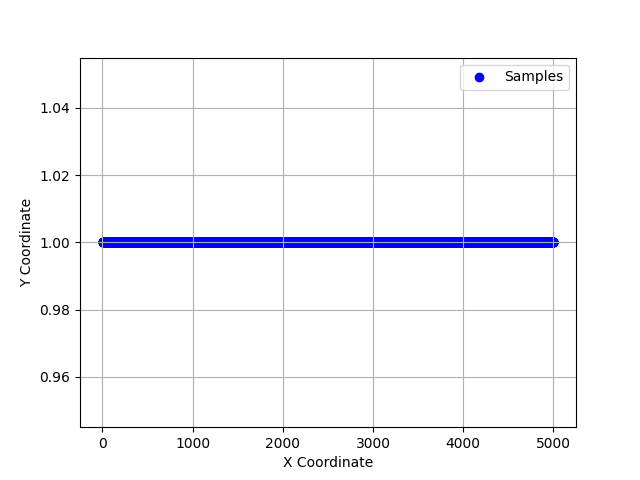

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt

def plot_samples(x_ord, y_ord):
    fig, ax = plt.subplots()
    ax.scatter(x_ord, y_ord, c='b', marker='o', label='Samples')
    #ax.set_aspect('equal', 'box')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.legend()
    plt.grid()
    plt.show()


plot_samples(x_ord, y_ord)

### RAILROAD GENERATION & DESIRED SPEED PROFILE
Find a spline (RAILROAD) that approximate the samples. More details on: https://docs.scipy.org/doc/scipy/reference/interpolate.html  
A desired speed profile is also found, such that never surpasses the maximum speed and adheres to the maximum acceleration constraints (-2,2)m/s².

***

_railroad.tck_: tuple, containing the following data:
- t: An array of the knots of the spline.
- c: An array of the coefficients of the spline.
- k: The degree of the spline.

_railroad.sample_distance_: chosen distance between samples of the calculated railroad  
_railroad.points_: array of "num_points" tuples (x, y, z, vmax) for each point on the railroad  
_railroad.u_: position of each data point along the spline, normalized between 0 and 1  
_railroad.vmax_ : array of maximum speed over distance (one sample each _sample_distance_)  
_railroad.vdes_ : array of desired speed over distance (one sample each _sample_distance_)  

In [7]:
from scipy.interpolate import splprep, splev

class Railroad:
    
    def __init__(self, x_ord, y_ord, z_ord, vmax_ord):

        # ------------------------------ 
        self.__vmax_ord = vmax_ord  
        # ------------------------------ 
        # CHANGE HERE FOR THE TEST THE OTHER ALGO
        #self.tck, self.u = splprep([x_ord, y_ord, z_ord], s=0, k=1)
        self.tck, self.u = splprep([x_ord, y_ord, z_ord], s=0, k=3)
        
        self.length = self.calculate_railroad_length()
        self.sample_distance = 1  # chosen distance between samples of the calculated railroad
        self.num_samples = int(self.length / self.sample_distance)
        self.points = self.generate_railroad_points()
        self.vmax = np.array([point[3] for point in self.points])
        self.vdes = self.compute_desired_speed_reference()


    
    def generate_railroad_points(self):
        ZeroToOne = np.linspace(0, 1, self.num_samples)
        out = splev(ZeroToOne, self.tck)
        points = np.column_stack((out[0], out[1], out[2]))

        # since the max speed is only given for a more sparse sample (u), we need to reconstruct it in our sample (z)
        vmax = []

        for z in ZeroToOne:
            # Find the nearest index in u for the current value of z, and assign it the corresponding max speed
            nearest_index = 0
            min_diff = abs(self.u[0] - z)
            for i in range(1, len(self.u)):
                diff = abs(self.u[i] - z)
                if diff < min_diff:
                    nearest_index = i
                    min_diff = diff

            vmax.append(self.__vmax_ord[nearest_index])

        vmax = np.array(vmax)
        points = np.column_stack((points, vmax))
        return points


    
    def calculate_railroad_length(self, num_points=100000):
        param_values = np.linspace(0, 1, num_points)
        coordinates = splev(param_values, self.tck)
        distances = np.sqrt(
            np.diff(coordinates[0])**2 +
            np.diff(coordinates[1])**2 +
            np.diff(coordinates[2])**2
        )
        total_length = np.sum(distances)
        return total_length


    
    def compute_desired_speed_reference(self):
        
        vmax = np.array([point[3] for point in self.points])
        sample_distance = self.sample_distance
        vdes = np.zeros_like(vmax)
        
        acc_max = 2        # maximum accelerations and decelerations are +2m/s^2 and -2m/s^2
        dec_max = 2

        anticipation_meters = 760             # I look ahead this meters and check if the train can decelerate enough to reach them
        anticipation_safety_lim_meters = 750  # meters that the train is decelerating ahead (to compensate delays in the real systems)
        anticipation = int(anticipation_meters / sample_distance)                        # I look ahead this samples and check ...
        anticipation_safety_lim = int(anticipation_safety_lim_meters / sample_distance)  # samples that the train is decelerating ahead ...
        
        vdes[0] = vmax[0]*(2/3) # initial condition
        for curr_index in range(1, len(vmax) - anticipation):

            # anticipating possible decelerations
            min_current_anticipation_sl = np.inf # sl: speed limit

            for ant_index in range(anticipation - anticipation_safety_lim):
                
                # calculating possible future decelerations, and the corresponding speed limit (sl); takes into consideration:
                # - a deceleration that is limited at 2 m/s^2, so it needs to be anticipated
                # - a deceleration that ends before it's virtually needed, to account for the delay in the real system
                # equation: v^2 = v0^2 + 2as

                current_anticipation_sl = math.sqrt(
                    (vmax[curr_index + ant_index + anticipation_safety_lim])**2 + 2 * dec_max * (ant_index * sample_distance) 
                )
                
                if current_anticipation_sl < min_current_anticipation_sl:
                    min_current_anticipation_sl = current_anticipation_sl

            # current speed limits, acording to every constrain
            current_sl = min( min_current_anticipation_sl, vmax[curr_index])

            # bang-bang controller with saturation
            if  current_sl > vdes[curr_index - 1]:
                vdes[curr_index] = np.sqrt( vdes[curr_index - 1]**2 + 2 * acc_max * sample_distance ) 

                if vdes[curr_index] > current_sl:
                    vdes[curr_index] = current_sl
                    
            elif  current_sl < vdes[curr_index - 1]:
                vdes[curr_index] = np.sqrt( vdes[curr_index - 1]**2 - 2 * dec_max * sample_distance ) 
                
                if vdes[curr_index] < current_sl:
                    vdes[curr_index] = current_sl
                    
            else:
                vdes[curr_index] = vdes[curr_index - 1]

        # last values are not avalaible since we need to look into the future
        vdes[-anticipation:] = vdes[-anticipation - 1]
        return vdes


railroad = Railroad(x_ord, y_ord, z_ord, vmax_ord)

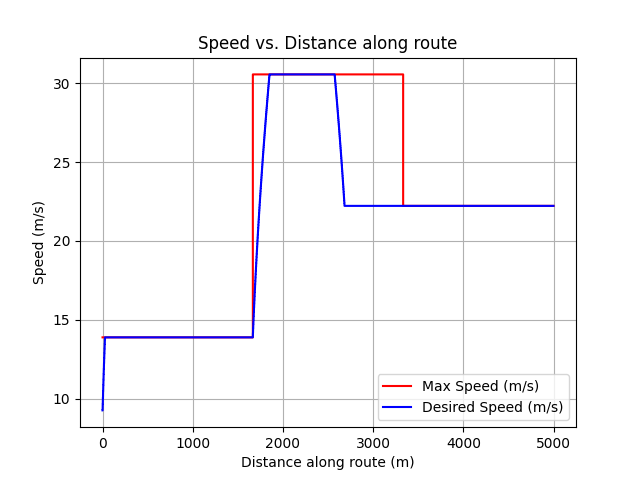

In [8]:
def plot_speed_over_distance(vmax, vdes, interval):
    fig, ax = plt.subplots()
    distances = np.arange(len(vmax)) * interval
    
    ax.step(distances, vmax, where='post', label='Max Speed (m/s)', color='red')
    ax.step(distances, vdes, where='post', label='Desired Speed (m/s)', color='blue')
    ax.set_xlabel('Distance along route (m)')
    ax.set_ylabel('Speed (m/s)')
    ax.set_title('Speed vs. Distance along route')
    ax.legend()
    ax.grid(True)
    plt.show()

plot_speed_over_distance(railroad.vmax, railroad.vdes, railroad.sample_distance)

### PLOT MAXIMUM AND DESIRED SPEED OVER DISTANCE

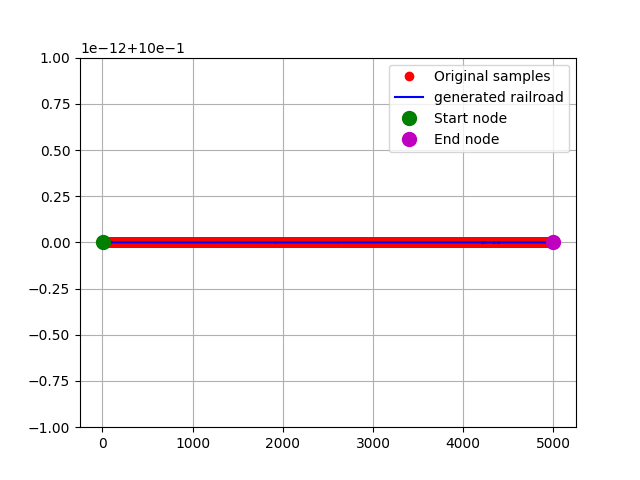

In [9]:
def plot_railroad(x_ord, y_ord, railroad):

    fig, ax = plt.subplots()
    ax.plot(x_ord, y_ord, 'ro', label='Original samples')
    ax.plot(railroad.points [:, 0], railroad.points [:, 1], 'b-', label='generated railroad')
    
    # Initial and final node
    ax.plot(x_ord[0], y_ord[0], 'go', markersize=10, label='Start node')  
    ax.plot(x_ord[-1], y_ord[-1], 'mo', markersize=10, label='End node')  
    
    #ax.set_aspect('equal', 'box')
    ax.legend()
    plt.grid()
    plt.show()

plot_railroad(x_ord, y_ord, railroad)

### PLOT THE SPLINE

### INTRINSIC KINEMATIK SIMULATION - POINT MASS MODEL

With the given desired speed profile, the intrinsic train kinematic is calculated, assuming that the train is a single mass point.

***
_train.s_: array of positions over time (every T)  
_train.s_dot_: array of speeds over time (every T)  
_train.s_ddot_: array of accelerations over time (every T)  
_train.s_dddot_: array of jerks over time (every T) 

<center>
    <img src="simulation.png" alt="UTM-ZONE" style="width: 100%; height: auto;">
</center>

In [10]:
class Train:
    
    def __init__(self, init_speed):
        # ---------------------------- state variables, at current time
        self.s_current = 30  # m                -- intrinsic position
        self.s_dot_current = init_speed  # m/s  -- intrinsic speed
        self.s_ddot_current = 0  # m/s^2        -- intrinsic accel.
        self.s_dddot_current = 0  # m/s^3       -- intrinsic jerk

        # ---------------------------- state variables, at past times
        self.s_dot_p = init_speed  # m/s      -- past speed
        self.s_dot_pp = init_speed  # m/s     -- past past speed
        self.s_dot_ppp = init_speed  # m/s    -- past past past speed
        
        self.s_ddot_p = 0  # m/s^2   -- past accel.
        self.s_ddot_pp = 0  # m/s^2  -- past past accel.
        self.s_ddot_ppp = 0  # m/s^2 -- past past accel.
        
        self.s_dddot_p = 0  # m/s^3  -- past jerk
        
        self.s_dot_des_current = init_speed  # m/s -- desired speed
        self.s_dot_des_p = init_speed  # m/s       -- past desired speed

        # ---------------------------- Arrays to store the simulation results
        self.s = np.array([self.s_current]) #             array of positions every T
        self.s_dot = np.array([self.s_dot_current]) #     array of speeds every T
        self.s_ddot = np.array([self.s_ddot_current]) #   array of accelerations every T
        self.s_dddot = np.array([self.s_dddot_current]) # array of jerks every T

        # ---------------------------- Stored integral error
        self.error_integral = 0
        

        self.advancements = np.array([])
        


    
    def update_acc(self, T):
        # update past and present jerks and accelerations
        self.s_ddot_ppp = self.s_ddot_pp
        self.s_ddot_pp = self.s_ddot_p
        self.s_ddot_p = self.s_ddot_current

        self.s_dddot_pp = self.s_dddot_p
        self.s_dddot_p = self.s_dddot_current

        # PID used to simulate the train system dynamics
        kp = 0.14
        kd = 0.016
        ki = 0
        error_past = self.s_dot_des_p - self.s_dot_p
        error_current = self.s_dot_des_current - self.s_dot_current
        self.error_integral += error_current * T
        self.s_ddot_current = kp * error_current + kd * error_past + ki * self.error_integral 

        max_accel = 2 # m/s^2
        max_jerk = 1 #  m/s^3

        # acceleration saturation
        if self.s_ddot_current > max_accel:
            self.s_ddot_current = max_accel
        elif self.s_ddot_current < -max_accel:
            self.s_ddot_current = -max_accel

        self.s_dddot_current = (self.s_ddot_current - self.s_ddot_p)/T

        # jerk saturation, also imposes corresponding acceleration
        if self.s_dddot_current > max_jerk:
            self.s_dddot_current = max_jerk
            self.s_ddot_current = self.s_ddot_current + (T/2) * (self.s_dddot_current + self.s_dddot_p)
            
        elif self.s_dddot_current < -max_jerk:
            self.s_dddot_current = -max_jerk
            self.s_ddot_current = self.s_ddot_current + (T/2) * (self.s_dddot_current + self.s_dddot_p)

        # acceleration saturation check after adjustment
        if self.s_ddot_current > max_accel:
            self.s_ddot_current = max_accel
        elif self.s_ddot_current < -max_accel:
            self.s_ddot_current = -max_accel


    
    def update_desired_speed(self, sample_distance, vdes_dist):
        delay = 30
        current_interval = int(self.s_current / sample_distance)
        self.s_dot_des_p = self.s_dot_des_current
        self.s_dot_des_current = vdes_dist[current_interval - delay]


    
    def integrate(self, T):
        # update past and present speeds 
        self.s_dot_ppp = self.s_dot_pp
        self.s_dot_pp = self.s_dot_p
        self.s_dot_p = self.s_dot_current
        
        # Adams-Bashforth 4 steps
        #self.s_dot_current = self.s_dot_current + (T / 24) * (55 * self.s_ddot_current - 59 * self.s_ddot_p + 37 * self.s_ddot_pp - 9 * self.s_ddot_ppp)
        #self.s_current = self.s_current + (T / 24) * (55 * self.s_dot_current - 59 * self.s_dot_p + 37 * self.s_dot_pp - 9 * self.s_dot_ppp)
        self.s_dot_current = self.s_dot_current + self.s_ddot_current * T
        self.s_current = self.s_current + self.s_dot_current * T

        self.advancements = np.append(self.advancements, self.s_dot_current * T)

        



    def kinematic_simulation(self, T, length, sample_distance, vdes_dist):
        while self.s_current < length - 10:
            self.update_desired_speed(sample_distance, vdes_dist)
            self.update_acc(T)
            self.integrate(T)

            self.s = np.append(self.s, self.s_current)
            self.s_dot = np.append(self.s_dot, self.s_dot_current)
            self.s_ddot = np.append(self.s_ddot, self.s_ddot_current)
            self.s_dddot = np.append(self.s_dddot, self.s_dddot_current)



T = 0.1 #s  -- system sampling time
train = Train(railroad.vdes[0])
train.kinematic_simulation(T, railroad.length, railroad.sample_distance, railroad.vdes)

### PLOT INTRINSIC DATA

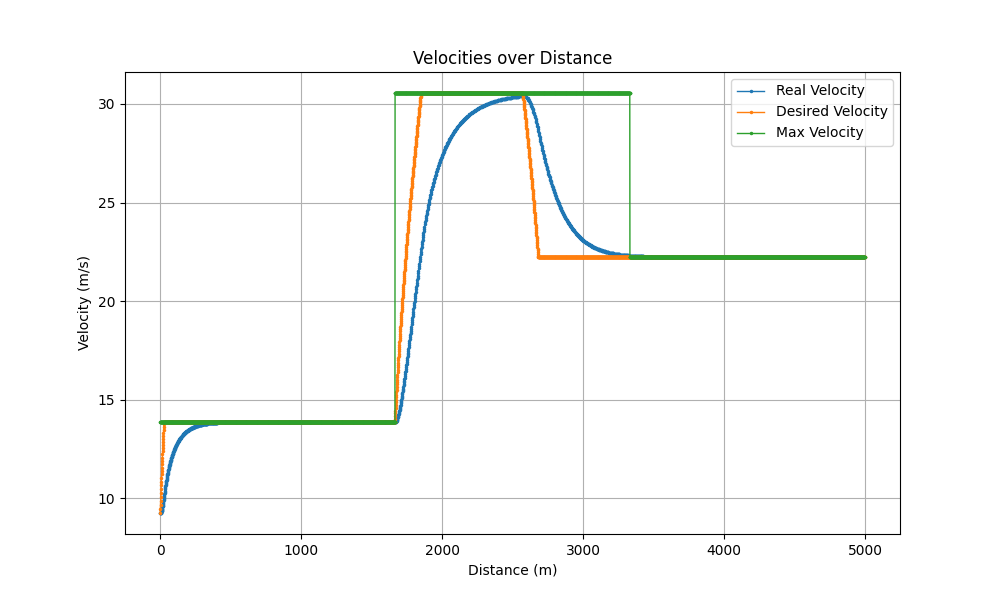

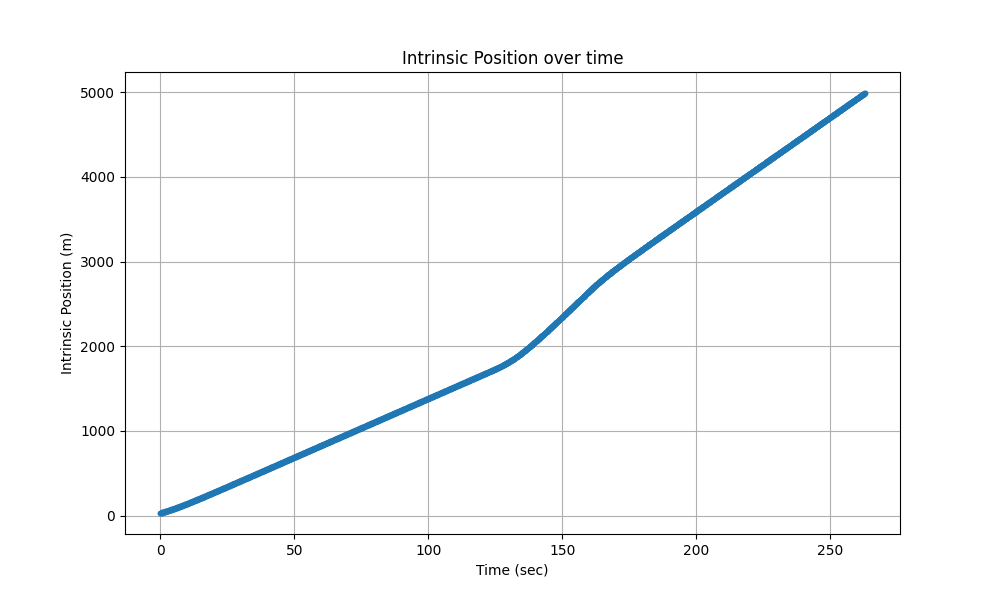

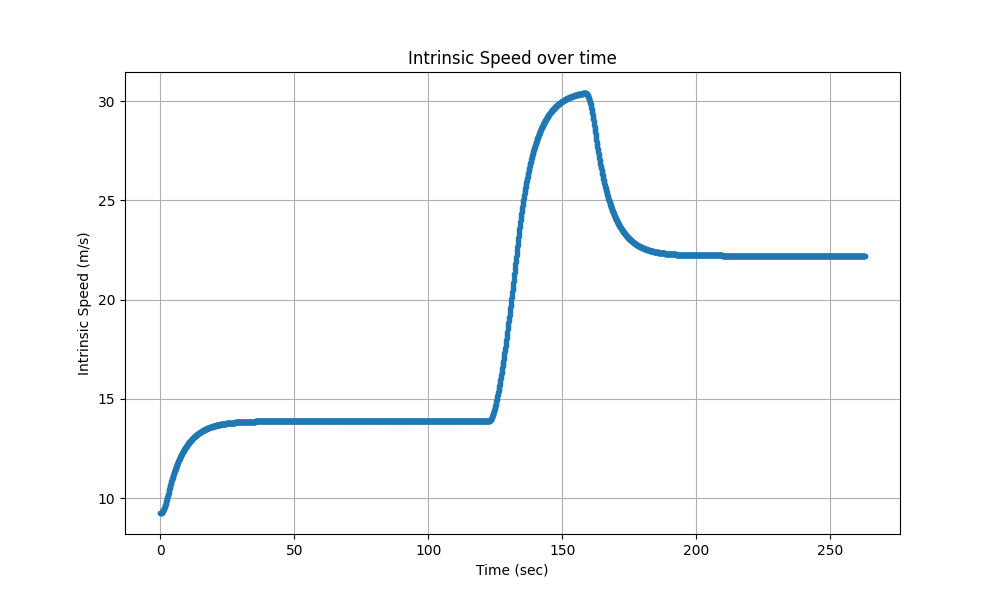

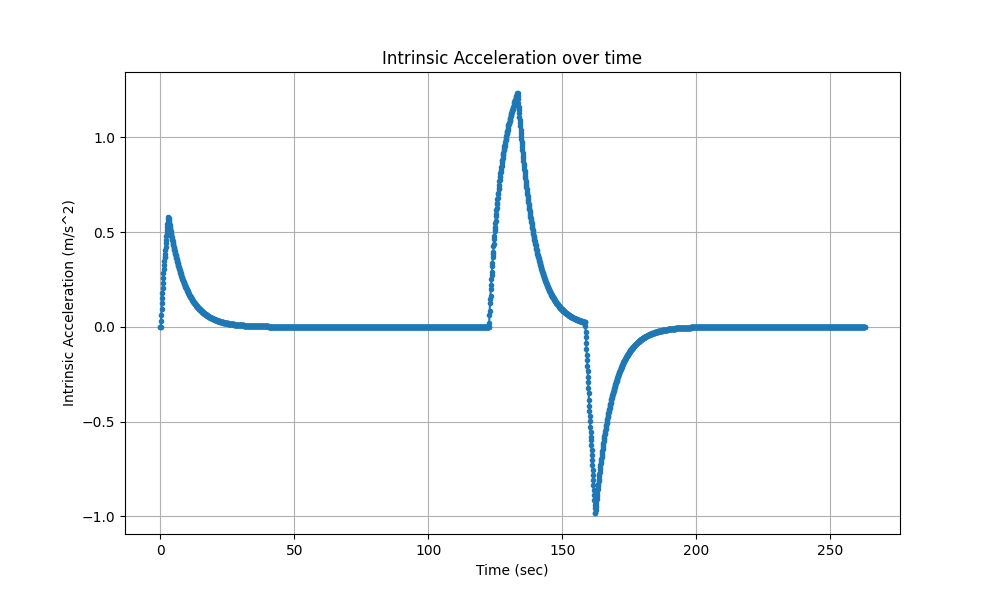

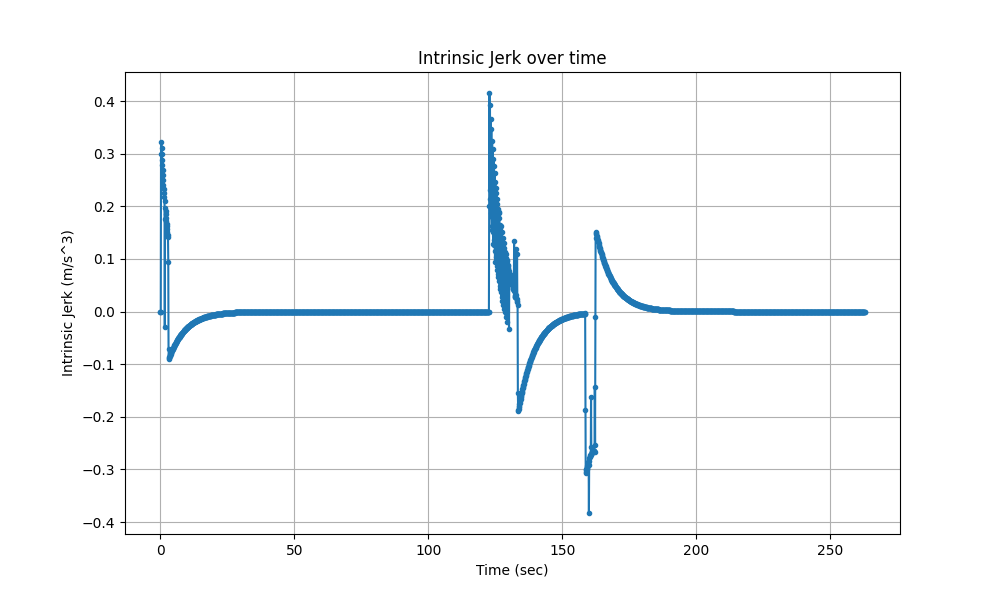

In [11]:
def plot_over_time(data, title, ylabel, T_sample):
    
    time = np.arange(0, len(data) * T_sample, T_sample)  # corrisponding time array
    if len(time) > len(data):
        time = time[:len(data)]

    plt.figure(figsize=(10, 6))
    plt.plot(time, data, marker='.')
    plt.title(title)
    plt.xlabel('Time (sec)')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()



def calculate_distances_from_velocity(velocity, T):
    distances = np.cumsum(velocity * T)  # cumulative sum
    return distances



def plot_velocities_over_distance(s_dot, vdes_dist, vmax_dist, T, sample_distance):

    distance_time_based = calculate_distances_from_velocity(s_dot, T)
    
    # create distance array
    num_samples_dist = len(vdes_dist)
    distances_dist_based = np.arange(0, num_samples_dist * sample_distance, sample_distance)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distance_time_based, s_dot, label='Real Velocity', marker='.', markersize=3, linewidth=1)
    plt.plot(distances_dist_based, vdes_dist, label='Desired Velocity', marker='.', markersize=3, linewidth=1)
    plt.plot(distances_dist_based, vmax_dist, label='Max Velocity', marker='.', markersize=3, linewidth=1)
    plt.title('Velocities over Distance')
    plt.xlabel('Distance (m)')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()
    plt.show()



plot_velocities_over_distance(train.s_dot, railroad.vdes, railroad.vmax, T, railroad.sample_distance)

plot_over_time(train.s, 'Intrinsic Position over time', 'Intrinsic Position (m)', T)
plot_over_time(train.s_dot, 'Intrinsic Speed over time', 'Intrinsic Speed (m/s)', T)
plot_over_time(train.s_ddot, 'Intrinsic Acceleration over time', 'Intrinsic Acceleration (m/s^2)', T)
plot_over_time(train.s_dddot, 'Intrinsic Jerk over time', 'Intrinsic Jerk (m/s^3)', T)




### CARTESIAN KINEMATIC ANALYSIS

In [12]:
def cartesian_kin(tck, s, s_dot, s_ddot, T, s_normalized):
    pos = splev(s_normalized, tck)
    der1 = splev(s_normalized, tck, der=1)

    # CHANGE HERE FOR THE TEST
    #der2  = der1
    der2 = splev(s_normalized, tck, der=2)

    

    X = np.array(pos[0])      
    Y = np.array(pos[1])  
    dx = np.array(der1[0])      
    dy = np.array(der1[1]) 
    ddx = np.array(der2[0])      
    ddy = np.array(der2[1]) 
    
    theta = np.arctan2(dy, dx)
    theta_dot = np.gradient(theta, T)  

    X_dot = s_dot * np.cos(theta)
    Y_dot = s_dot * np.sin(theta)
    X_ddot = s_ddot * np.cos(theta)
    Y_ddot = s_ddot * np.sin(theta)

    return X, Y, X_dot, Y_dot, X_ddot, Y_ddot, theta, theta_dot

s_normalized = train.s/railroad.length
X, Y, X_dot, Y_dot, X_ddot, Y_ddot, theta, theta_dot = cartesian_kin(railroad.tck, train.s, train.s_dot, train.s_ddot, T, s_normalized)

theta_deg = theta * 180 / np.pi
theta_deg = theta_deg % 360
theta_dot_deg = theta_dot * 180 / np.pi

# Speed and acceleration module
velocity_magnitude = np.sqrt(X_dot**2 + Y_dot**2)
acceleration_magnitude = np.sqrt(X_ddot**2 + Y_ddot**2)

### PLOT CARTESIAN DATA

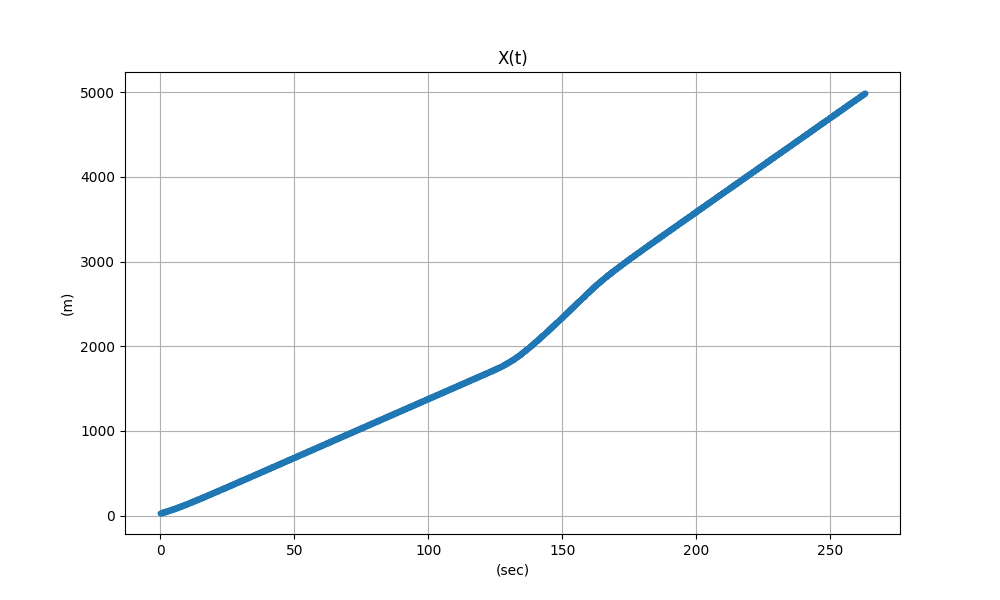

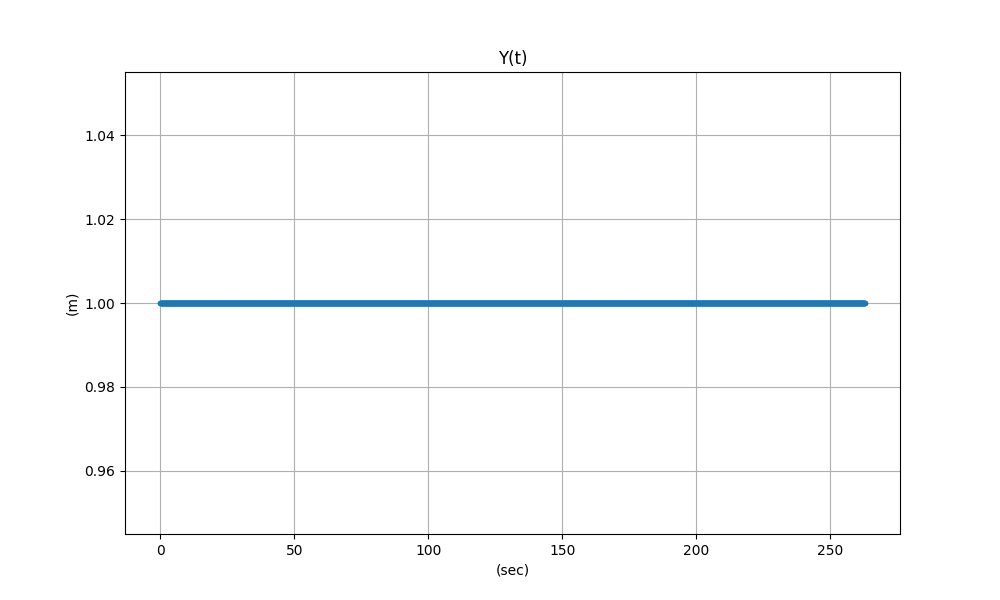

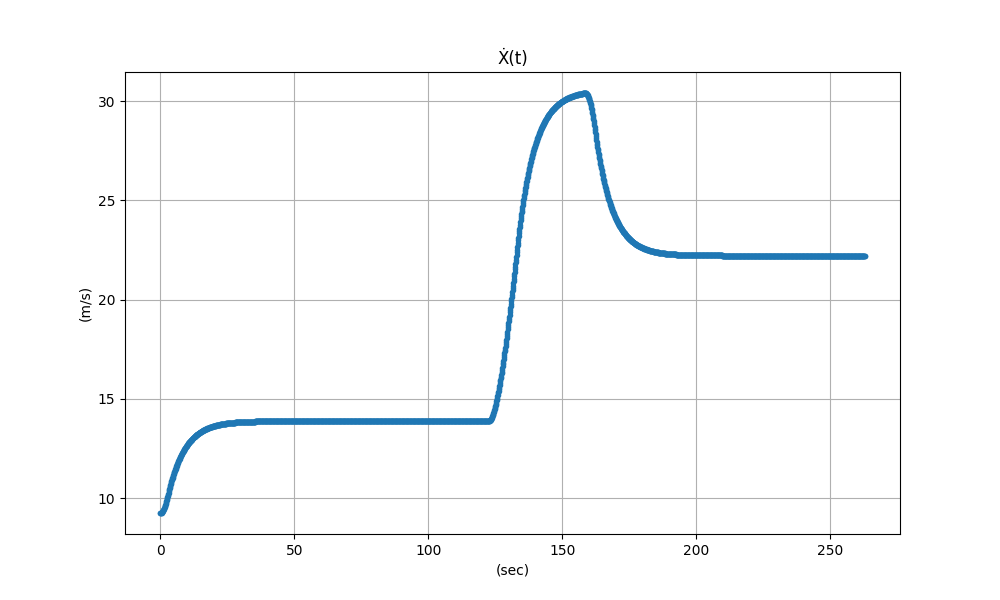

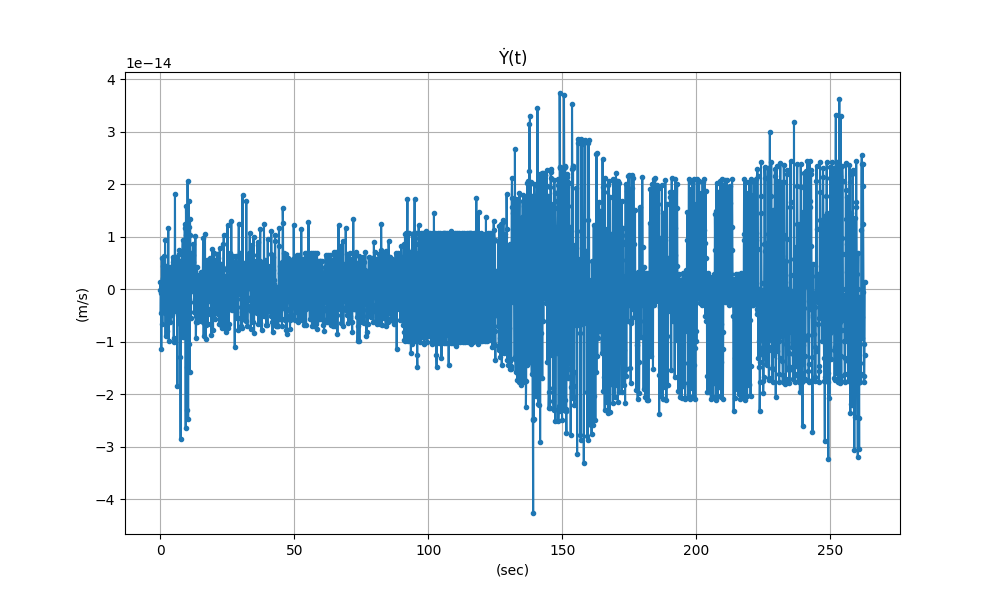

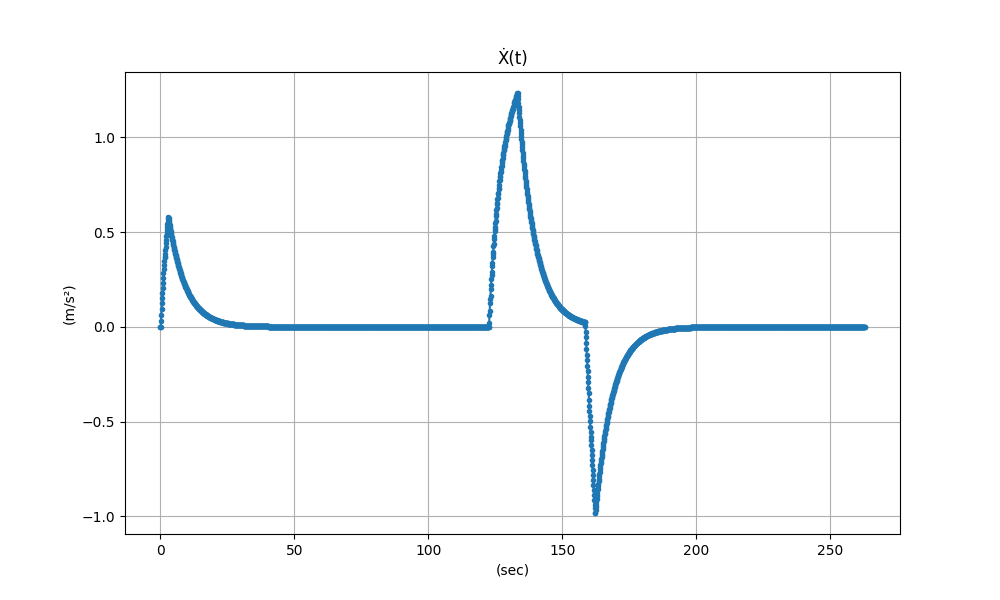

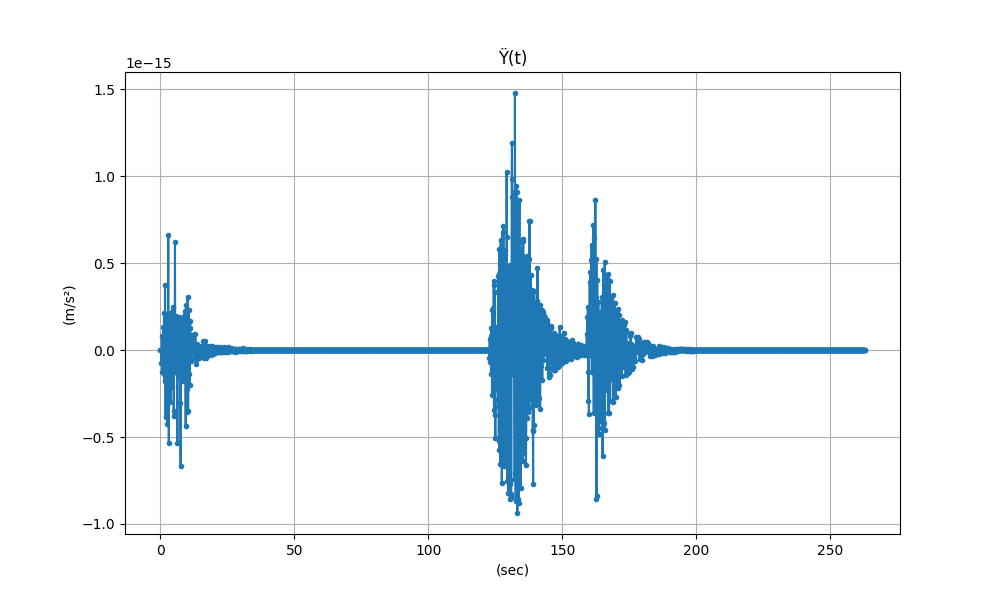

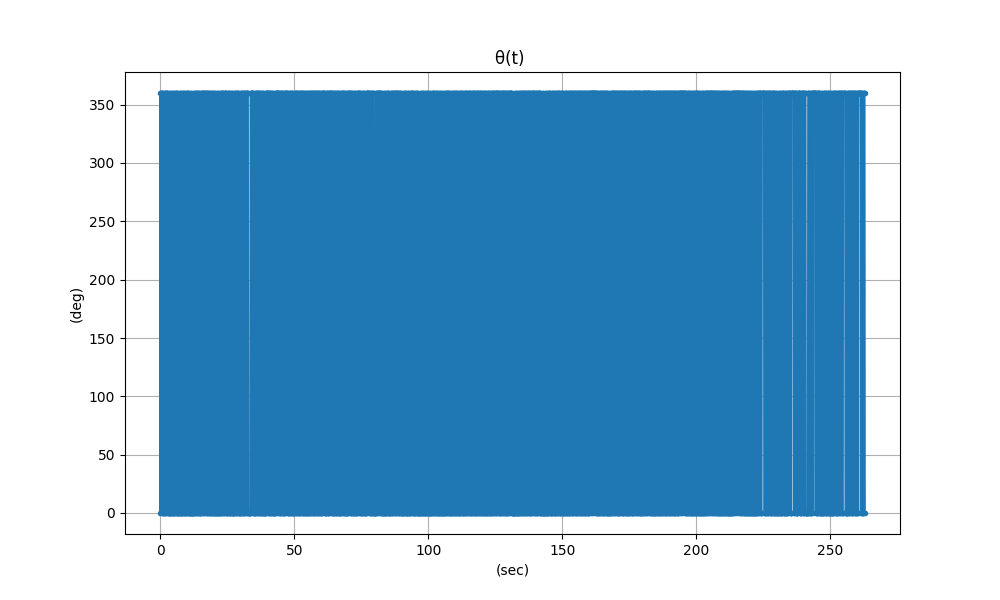

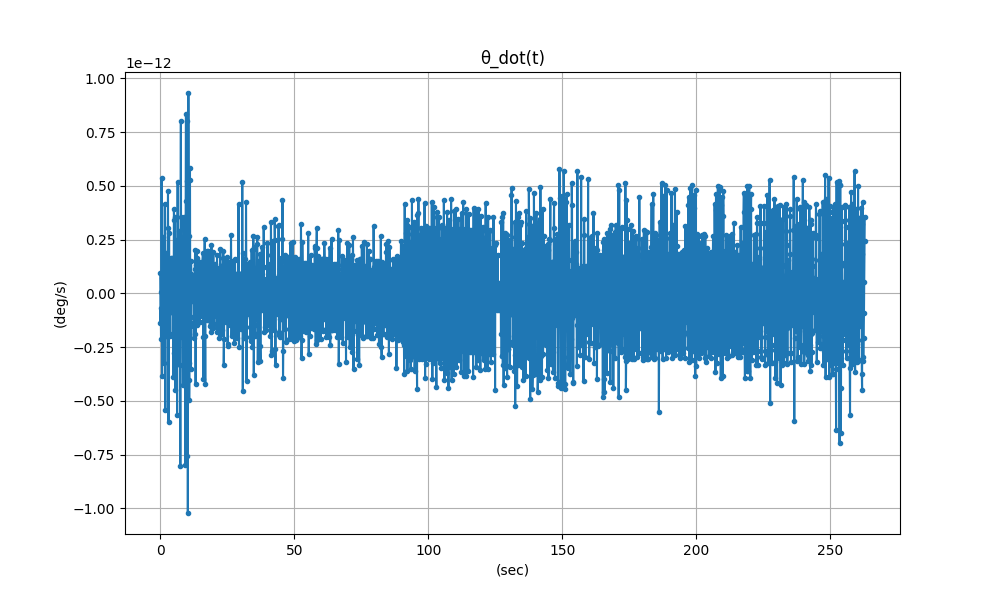

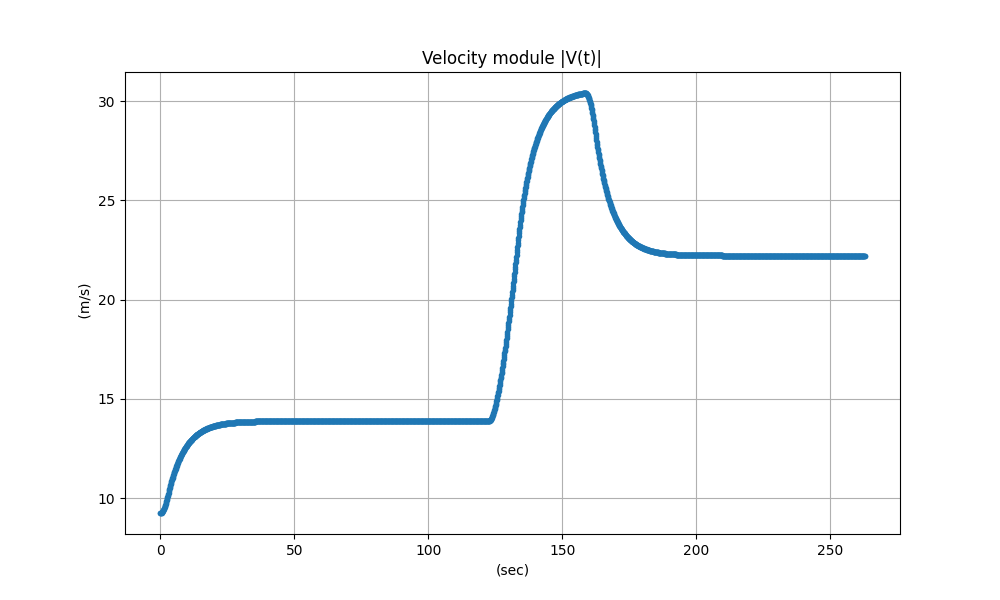

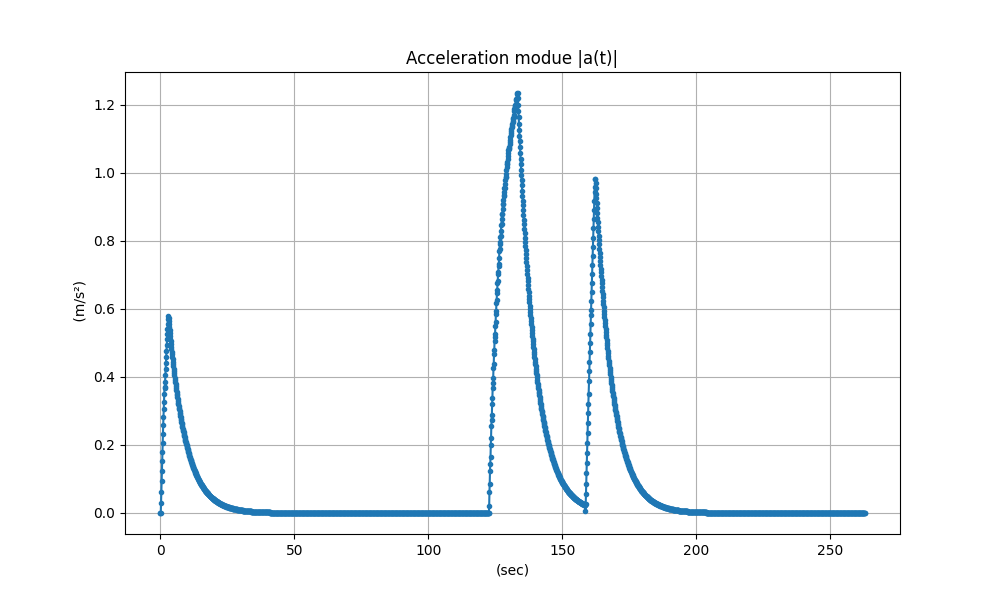

In [13]:
def plot_over_time(data, title, ylabel, T_sample):
    time = np.arange(0, len(data) * T_sample, T_sample)  # corrisponding time array

    # check
    if len(time) > len(data):
        time = time[:len(data)]

    plt.figure(figsize=(10, 6))
    plt.plot(time, data, marker='.')
    plt.title(title)
    plt.xlabel('(sec)')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

plot_over_time(X, 'X(t)', '(m)', T)
plot_over_time(Y, 'Y(t)', '(m)', T)
plot_over_time(X_dot, 'Ẋ(t)', '(m/s)', T)
plot_over_time(Y_dot, 'Ẏ(t)', '(m/s)', T)
plot_over_time(X_ddot, 'Ẋ(t)', '(m/s²)', T)
plot_over_time(Y_ddot, 'Ÿ(t)', '(m/s²)', T)
plot_over_time(theta_deg, 'θ(t) ', '(deg)', T)
plot_over_time(theta_dot_deg, 'θ_dot(t)', '(deg/s)', T)

# to verify results
plot_over_time(velocity_magnitude, 'Velocity module |V(t)|', ' (m/s)', T)
plot_over_time(acceleration_magnitude, 'Acceleration modue |a(t)|', ' (m/s²)', T)

### KINEMATIK SIMULATION - DOUBLE CART (DC) MODEL
I assume the found (s) positions being relative to the front cart: now I look for the back positions (s_back).
To do this I suppose that the train never go back, and I iteratively look for positions in the spline that are at the exact distance (carriage_len) to the front positions

max error, absolute value: 8.391509709326783e-12


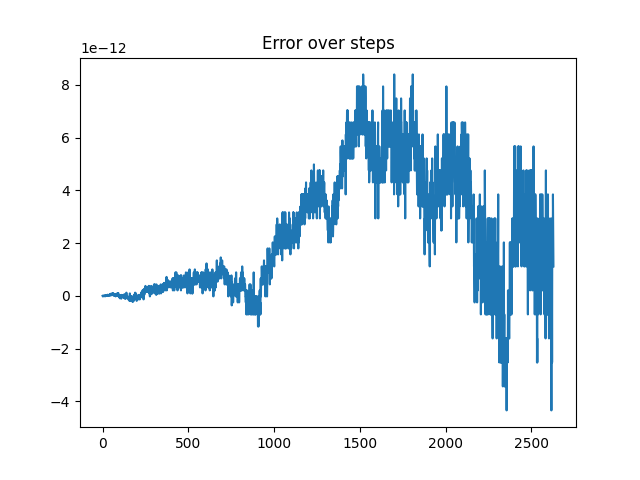

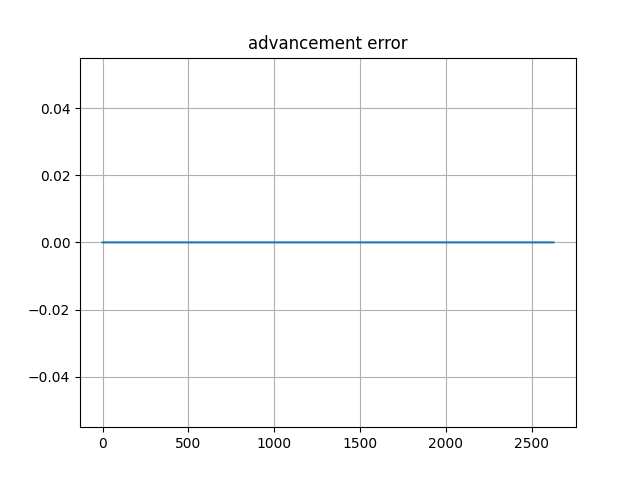

In [14]:
from scipy import interpolate
from scipy.integrate import quad

class TrainDC:
    
    def __init__(self, carriage_len, s_normalized, tck, s_dot, T):
        # ---------------------------------- 
        self.__s_normalized = s_normalized
        self.__s_dot = s_dot
        self.__tck = tck

        # ---------------------------------- 
        # train
        self.carriage_len = carriage_len
        self.T = T
        
        # back cart
        self.s_back_norm = np.array([], np.float32)
        self.X_back = None
        self.Y_back = None

        # center
        self.X_center = None
        self.Y_center = None
        self.X_dot_center = None
        self.Y_dot_center = None
        self.V_center = None
        self.X_ddot_center = None
        self.Y_ddot_center = None
        self.A_center = None
        self.theta_center = None
        self.theta_dot_center = None
        self.theta_deg_center = None
        self.theta_dot_deg_center = None

        self.advancements = np.array([])
        

    def get_s_dot(self):
        return self.__s_dot


    # -------------------------------------------------------------------------
    # Initial back position
    # -------------------------------------------------------------------------

    def find_initial_back_pos(self):
        # to find the first back cart position, I brute-force sample the spline and compute the distance, then I choose the best 
        # sample (closest to the correct distance) and I start again from a close range of the point that for another sample

        num_iteration = 8
        num_sample = 10 # for each iteration

        # set initial guesses (most forward and most backward) for the initial position of the back cart
        minS_norm = 0
        maxS_norm = self.__s_normalized[0]
        x_front, y_front = splev(maxS_norm, self.__tck)[:2] # position of the front cart

        for iteration in range(num_iteration):
            samples_norm = np.linspace(minS_norm, maxS_norm, num_sample) # sample the spline and use it as guesses guesses
            x_samples, y_samples = splev(samples_norm, self.__tck)[:2]

            min_error_dist_index = -1
            min_error_dist = np.inf

            for sample_index in range(1, len(x_samples) - 1):
                dist = np.sqrt(((x_samples[sample_index] - x_front) ** 2) + ((y_samples[sample_index] - y_front) ** 2))
                error_dist = abs(dist - self.carriage_len)

                if min_error_dist > error_dist:
                    min_error_dist = error_dist
                    min_error_dist_index = sample_index

            minS_norm = samples_norm[min_error_dist_index - 1]
            maxS_norm = samples_norm[min_error_dist_index + 1]
            s_back = samples_norm[min_error_dist_index]

        return s_back # first back cart position


    
    # -------------------------------------------------------------------------
    # I method
    # -------------------------------------------------------------------------
    
    def div_et_imp(self, front_dist_norm, back_pos_guess_min, back_pos_guess_max, s_norm, front_index):
        
        x_front_dist, y_front_dist = splev(s_norm[front_index], self.__tck)[:2] # current x,y position of the front cart
        # search algorithm for the back cart position. 
        # starting from known position of the front cart and upper and lower bound of the current position of the back cart
        
        # Divides the railway segment in between the two -> [guess_backward, guess_mid] - [guess_mid, guess_forward]
        # Looks for the middle point in each interval
        # Choose the interval in which the middle point has a distance to the front cart closer to the actual one (carriage_len)

        guess_mid = (back_pos_guess_max + back_pos_guess_min) / 2 # current best guess
        guess_forward = (guess_mid + back_pos_guess_max) / 2     # guess upper limit
        guess_backward = (guess_mid + back_pos_guess_min) / 2     # guess lower limit

        x_guess_forward, y_guess_forward = splev(guess_forward, self.__tck)[:2] # current x,y position of the most forward guess
        x_guess_backward, y_guess_backward = splev(guess_backward, self.__tck)[:2] # current x,y position of the most backward guess

        distance_forward = np.sqrt((x_front_dist - x_guess_forward) ** 2 + (y_front_dist - y_guess_forward) ** 2)
        distance_backward = np.sqrt((x_front_dist - x_guess_backward) ** 2 + (y_front_dist - y_guess_backward) ** 2)

        error_forward = abs(self.carriage_len - distance_forward)
        error_backward = abs(self.carriage_len - distance_backward)

        if error_forward < error_backward:
            # the back cart is closer to the forward guess
            return guess_forward, guess_mid, back_pos_guess_max, error_forward

        # the back cart is closer to the backward guess
        return guess_backward, back_pos_guess_min, guess_mid, error_backward


    
    def distance_along_spline(self, s1, s2):
        if s1 > s2:
            s1, s2 = s2, s1

        def deriv_spline(t, tck):
            derivs = interpolate.splev(t, tck, der=1)
            return np.sqrt(derivs[0] ** 2 + derivs[1] ** 2)

        distance, _ = quad(deriv_spline, s1, s2, args=(self.__tck,))
        return distance


    
    def find_back_pos(self, s_norm, back_pos_guess_norm, front_index, s):
        front_pos_norm = s_norm[front_index] # current front position

        # set the guess for minimum and maximum position where the back cart can be place
        front_dist = self.distance_along_spline(s_norm[front_index], s_norm[front_index - 1])  # distance traveled by the front cart
        front_dist_norm = front_dist / (np.max(s)) # normalized distance traveled by the front cart

        # set the upper and lower bound for the distance traveled by the back cart (as a normalized intrinsic distance)
        # CAN BE IMPROVED
        max_inc_guess_norm = 3 * front_dist_norm
        min_inc_guess_norm = 0

        back_pos_guess_max_norm = back_pos_guess_norm + max_inc_guess_norm
        back_pos_guess_min_norm = back_pos_guess_norm + min_inc_guess_norm
        back_pos_guess_norm = (back_pos_guess_min_norm + back_pos_guess_max_norm) / 2 # best guess of the back cart position

        # Search stop criteria
        max_error_allowed = 0.00001
        num_iteration_max = 40

        # Back cart position search algorithm
        dist_error = np.inf
        num_iteration = 0
        while dist_error > max_error_allowed and num_iteration < num_iteration_max:
            back_pos_guess_norm, back_pos_guess_min_norm, back_pos_guess_max_norm, dist_error = self.div_et_imp(
                front_dist_norm, back_pos_guess_min_norm, back_pos_guess_max_norm, s_norm, front_index)
            num_iteration += 1
        return back_pos_guess_norm


    
    def compute_back_positions(self, s):
        
        self.X_back = np.array([])
        self.Y_back = np.array([])
        back_pos_guess_norm = self.find_initial_back_pos()
        self.s_back_norm = np.append(self.s_back_norm, back_pos_guess_norm)

        for front_index in range(1, len(s)):
            self.s_back_norm = np.append(self.s_back_norm, self.find_back_pos(self.__s_normalized, back_pos_guess_norm, front_index, s))
            back_pos_guess_norm = self.s_back_norm[front_index]

        self.X_back, self.Y_back = splev(self.s_back_norm, self.__tck)[:2]

    # -------------------------------------------------------------------------
    # I method
    # -------------------------------------------------------------------------
    
    def compute_back_positions_w(self, s, length):
        
        self.X_back = np.array([])
        self.Y_back = np.array([])
        back_pos_guess_norm = self.find_initial_back_pos() 
        self.s_back_norm = np.array([back_pos_guess_norm])
    
        for i in range(1, len(s)):
            
            v_front = self.__s_dot[i]   # intrinsic velocity of the front cart
            ds = v_front * self.T       # compute next back position by moving it along the spline
            s_back_past = self.s_back_norm[i-1]            
            s_current = s_back_past + ds / length   # advance in the spline
            self.s_back_norm = np.append(self.s_back_norm, s_current)
            self.advancements = np.append(self.advancements, ds)


        self.X_back, self.Y_back = splev(self.s_back_norm, self.__tck)[:2]


    
    # -------------------------------------------------------------------------
    # center kinematics
    # -------------------------------------------------------------------------

    def compute_center_positions(self, X, Y):
        self.X_center = (X.copy() + self.X_back) / 2
        self.Y_center = (Y.copy() + self.Y_back) / 2


    
    def center_cartesian_kin(self, T=0.1):
        # speed
        self.X_dot_center = np.diff(self.X_center) / T
        self.Y_dot_center = np.diff(self.Y_center) / T
        self.V_center = np.sqrt(self.X_dot_center**2 + self.Y_dot_center**2) / T  # speed module

        # acceleration
        self.X_ddot_center = np.diff(self.X_dot_center) / T
        self.Y_ddot_center = np.diff(self.Y_dot_center) / T
        self.A_center = np.diff(self.V_center) / T  # acceleration module

        # orientation and angular speed
        self.theta_center = np.arctan2(self.Y_dot_center, self.X_dot_center)
        self.theta_dot_center = np.diff(self.theta_center) / T

        # we want all arrays to have the same size, but the first components are needed for the differentiations
        # also, the first samples are very noisy, so I remove it
        num_noisy_sample = 4
        self.X_center = self.X_center[2 + num_noisy_sample:]
        self.Y_center = self.Y_center[2 + num_noisy_sample:]
        
        self.X_dot_center = self.X_dot_center[1 + num_noisy_sample:]
        self.Y_dot_center = self.Y_dot_center[1 + num_noisy_sample:]
        
        self.X_ddot_center = self.X_ddot_center[num_noisy_sample:]
        self.Y_ddot_center = self.Y_ddot_center[num_noisy_sample:]
        
        self.theta_center = self.theta_center[num_noisy_sample + 1:]
        self.theta_dot_center = self.theta_dot_center[num_noisy_sample:]

        # convert to degrees
        self.theta_deg_center = self.theta_center * 180 / np.pi
        self.theta_dot_deg_center = self.theta_dot_center * 180 / np.pi

    
    def compute_max_error(self, X, Y):
        distances = np.sqrt((X[:] - self.X_back[:])**2 + (Y[:] - self.Y_back[:])**2)
        return distances - self.carriage_len


# --------------------------------------------------------------
# Train Double Cart (DC) model 
carriage_len = 25 # meters
train_dc = TrainDC(carriage_len, s_normalized, railroad.tck, train.s_dot, T)

# 2 methods for calculating the back kinematics: uncomment the one it's wanted
train_dc.compute_back_positions_w(train.s, railroad.length)
#train_dc.compute_back_positions(train.s)

train_dc.compute_center_positions(X.copy(), Y.copy())
train_dc.center_cartesian_kin(T)
max_err = train_dc.compute_max_error(X.copy(), Y.copy())
print(f"max error, absolute value: {max(abs(max_err - max_err[0]))}")


# --------------------------------------------------------
plt.figure()
plt.title('Error over steps')
plt.plot(max_err - max_err[0]) # offset by the error in the initial condition
plt.show()
# --------------------------------------------------------
plt.figure()
plt.title('advancement error')
plt.plot(train_dc.advancements - train.advancements)
plt.grid()
plt.show()
# --------------------------------------------------------






#### PLOT CENTER KINEMATICS

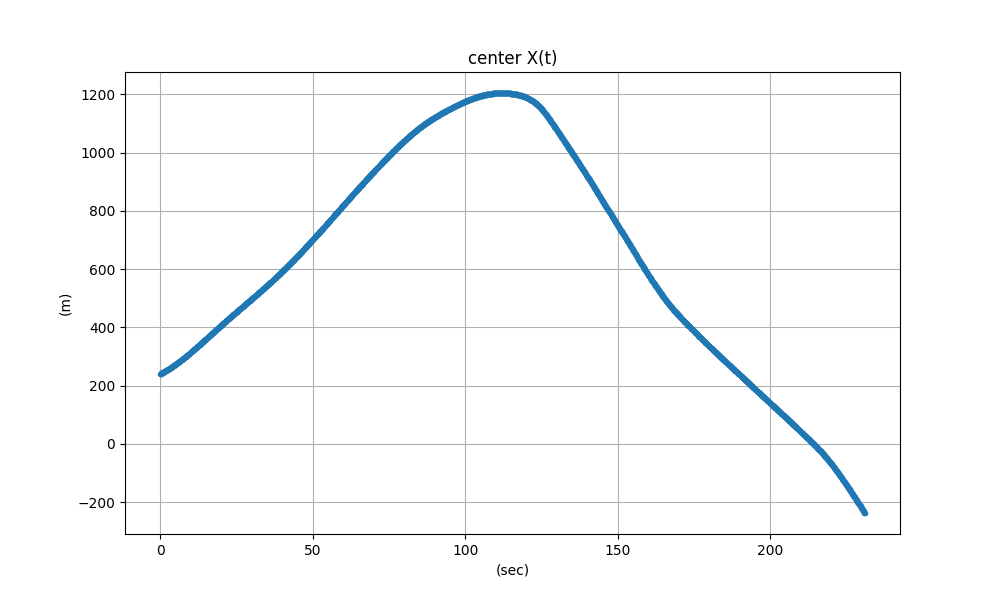

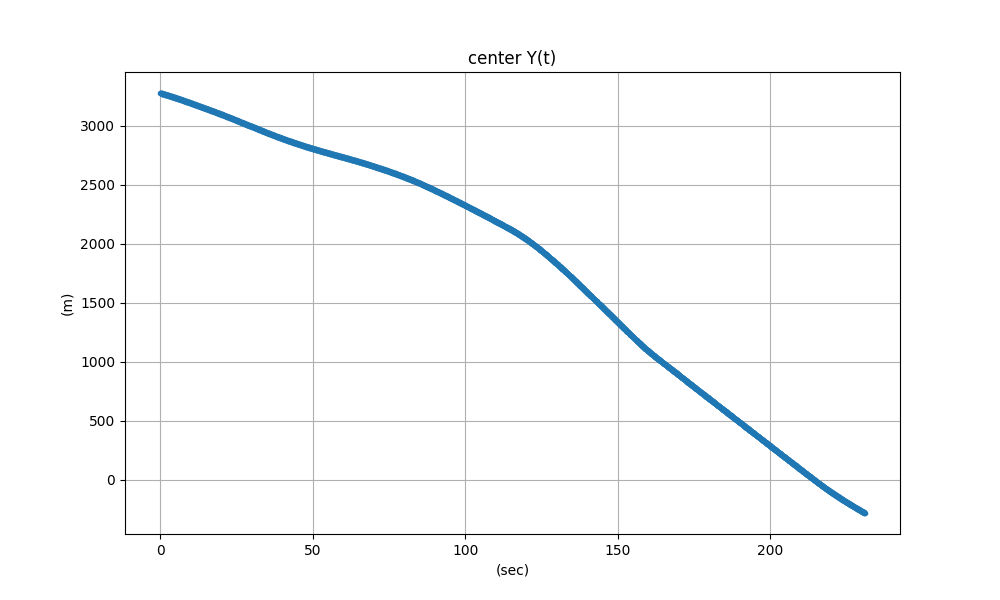

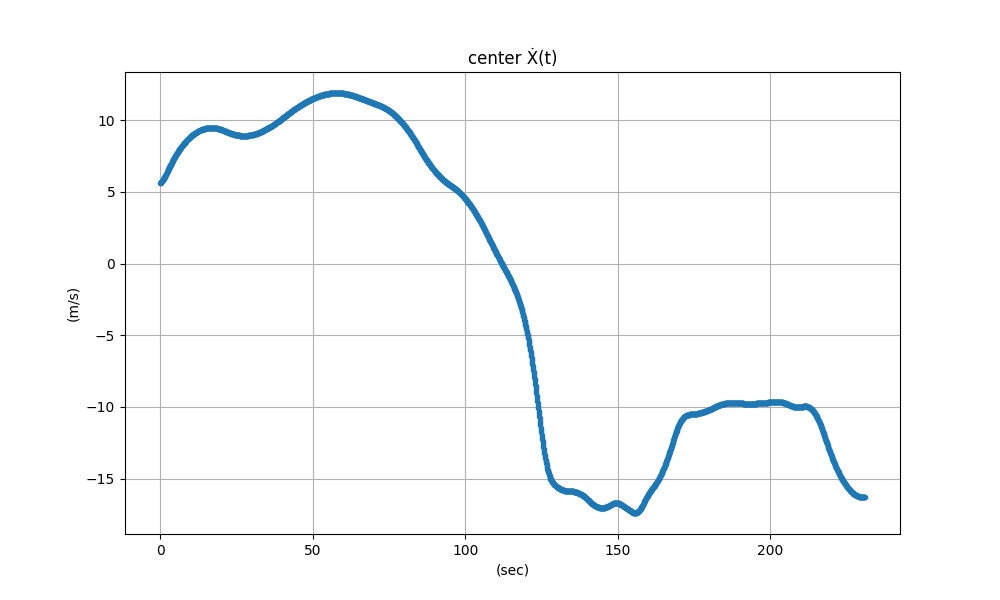

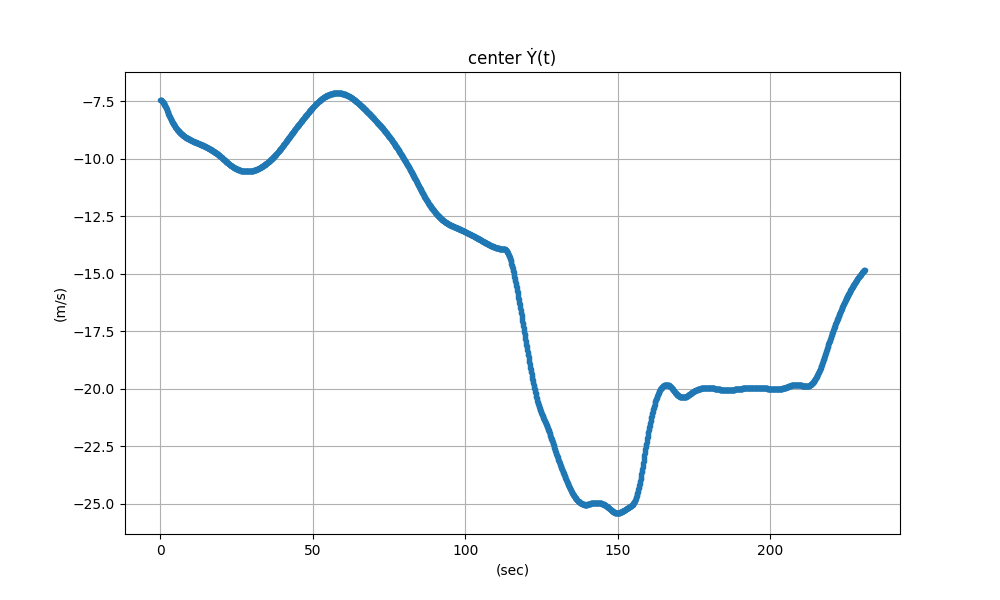

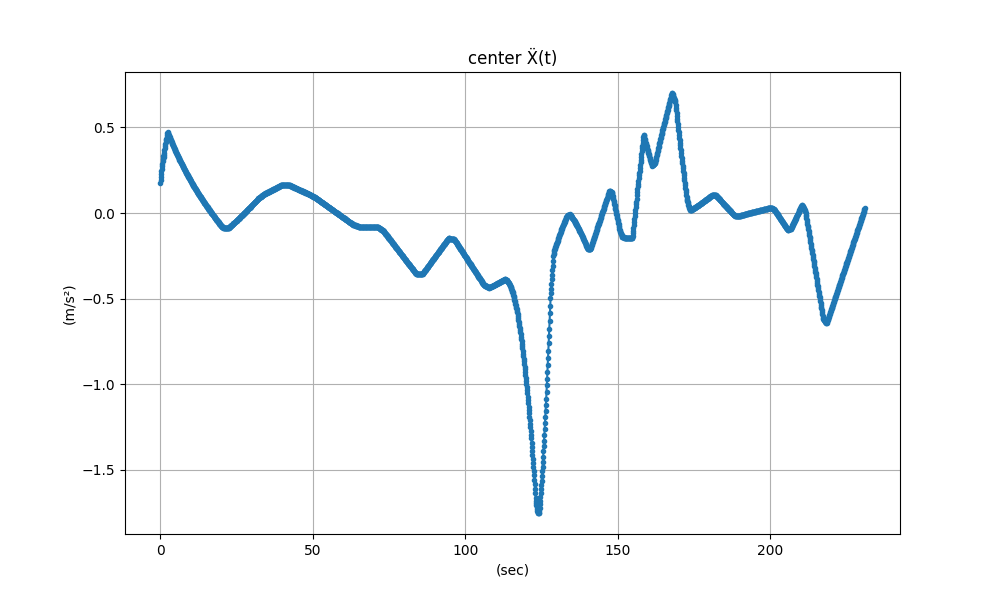

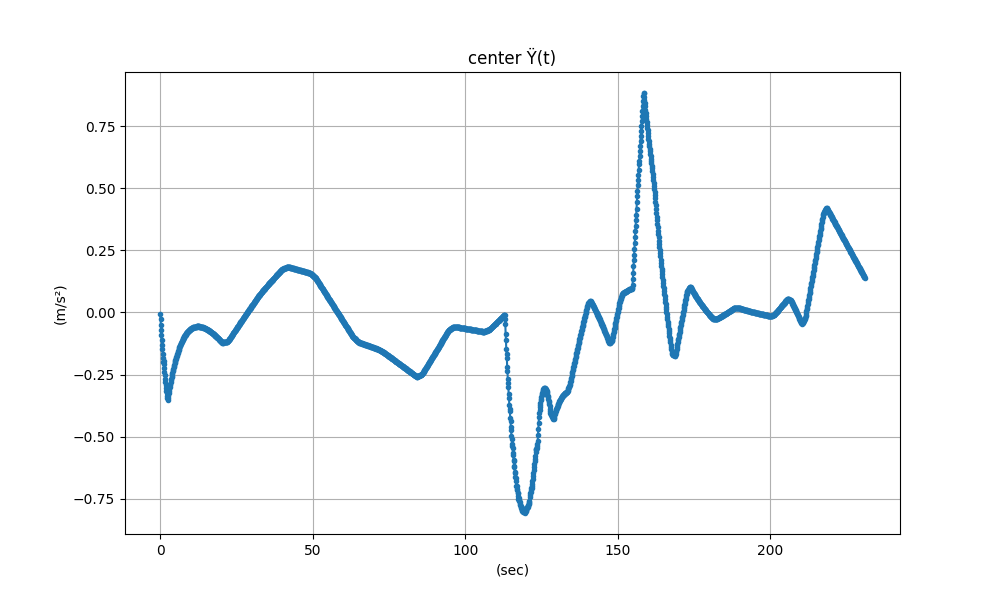

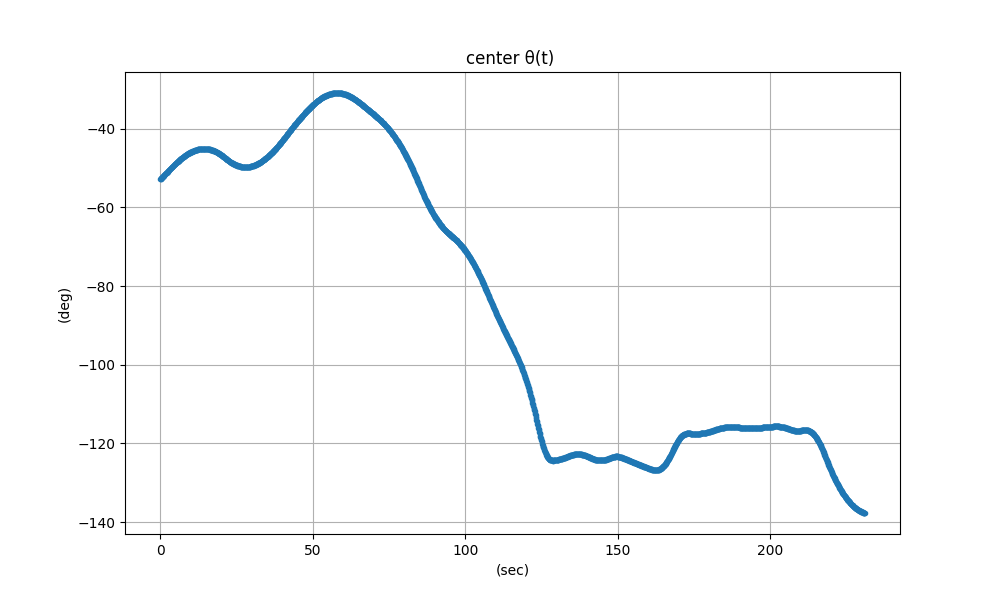

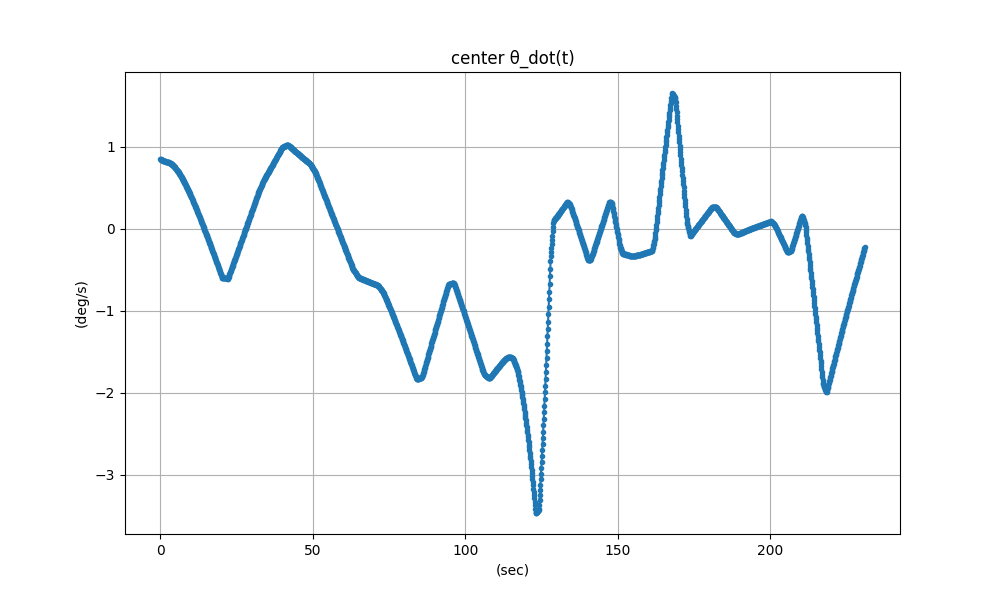

In [20]:
plot_over_time(train_dc.X_center, 'center X(t)', '(m)', T)
plot_over_time(train_dc.Y_center, 'center Y(t)', '(m)', T)

plot_over_time(train_dc.X_dot_center, 'center Ẋ(t)', '(m/s)', T)
plot_over_time(train_dc.Y_dot_center, 'center Ẏ(t)', '(m/s)', T)

plot_over_time(train_dc.X_ddot_center, 'center Ẍ(t)', '(m/s²)', T)
plot_over_time(train_dc.Y_ddot_center, 'center Ÿ(t)', '(m/s²)', T)

plot_over_time(train_dc.theta_deg_center, 'center θ(t) ', '(deg)', T)
plot_over_time(train_dc.theta_dot_deg_center, 'center θ_dot(t)', '(deg/s)', T)

### TRAIN ANIMATION

animation of the train moving along the railroad.  
Use _speedfactor_ to adjust the desired time speed

In [21]:
X_back = train_dc.X_back
Y_back = train_dc.Y_back
X_center = train_dc.X_center
Y_center = train_dc.Y_center
X_dot_center = train_dc.X_dot_center
Y_dot_center = train_dc.Y_dot_center
V_center = train_dc.V_center
X_ddot_center = train_dc.X_ddot_center
Y_ddot_center = train_dc.Y_ddot_center
A_center = train_dc.A_center
theta_center = train_dc.theta_center
theta_dot_center = train_dc.theta_dot_center
theta_deg_center = train_dc.theta_deg_center
theta_dot_deg_center = train_dc.theta_dot_deg_center


# resize all the positions array to be the same
desired_dim = X_center.size
X_back = X_back[-desired_dim:]
Y_back = Y_back[-desired_dim:]
X = X[-desired_dim:]
Y = Y[-desired_dim:]
X_dot = X_dot[-desired_dim:]
Y_dot = Y_dot[-desired_dim:]
Y_ddot = Y_ddot[-desired_dim:]
Y_ddot = Y_ddot[-desired_dim:]






import matplotlib.animation as animation
from matplotlib.patches import Circle

def animate_train_circle(X, Y, X_back, Y_back, X_center, Y_center, tck, carriage_len, speed_factor=1, T=0.1):
    
    # Create the figure and animation objects
    fig, ax = plt.subplots()

    # Sample the spline to recreate the railway trajectory
    u_fine = np.linspace(0, 1, 1000)
    X_spline, Y_spline = splev(u_fine, tck)[:2]
    ax.plot(X_spline, Y_spline, 'k--', lw=1, alpha=0.3)  # Railway trajectory

    line, = ax.plot([], [], 'b-', lw=2)  # Train line
    point_front, = ax.plot([], [], 'ro')  # Front cart
    point_back, = ax.plot([], [], 'go')  # Back cart
    point_center, = ax.plot([], [], 'bo')  # Central position

    # Initialize the circle
    circle = Circle((0, 0), carriage_len, color='r', fill=False)
    ax.add_patch(circle)

    ax.set_xlim(np.min(X_spline)-30, np.max(X_spline)+30)
    ax.set_ylim(np.min(Y_spline)-30, np.max(Y_spline)+30)
    #ax.set_aspect('equal', 'box')

    # Create the animation
    def update(num, X, Y, X_back, Y_back, X_center, Y_center, line, point_front, point_back, point_center, circle):
        line.set_data([X[num], X_back[num]], [Y[num], Y_back[num]])
        point_front.set_data(X[num], Y[num])
        point_back.set_data(X_back[num], Y_back[num])
        point_center.set_data(X_center[num], Y_center[num])
        circle.set_center((X[num], Y[num]))  # Update the circle position
        return line, point_front, point_back, point_center, circle
        
    frame_interval = T * 1000 / speed_factor
    ani = animation.FuncAnimation(fig, update, frames=range(len(X)),
                                  fargs=(X, Y, X_back, Y_back, X_center, Y_center, line, point_front, point_back, point_center, circle),
                                  interval=frame_interval)
    plt.grid(True)
    plt.show()


def animate_train(X, Y, X_back, Y_back, X_center, Y_center, tck, carriage_len, speed_factor=1, T=0.1):
    
    # Create the figure and animation objects
    fig, ax = plt.subplots()

    # Sample the spline to recreate the railway trajectory
    u_fine = np.linspace(0, 1, 1000)
    X_spline, Y_spline = splev(u_fine, tck)[:2]
    ax.plot(X_spline, Y_spline, 'k--', lw=1, alpha=0.3)  # Railway trajectory

    line, = ax.plot([], [], 'b-', lw=2)  # Train line
    point_front, = ax.plot([], [], 'ro')  # Front cart
    point_back, = ax.plot([], [], 'go')  # Back cart
    point_center, = ax.plot([], [], 'bo')  # Central position


    ax.set_xlim(np.min(X_spline)-30, np.max(X_spline)+30)
    ax.set_ylim(np.min(Y_spline)-30, np.max(Y_spline)+30)
    ax.set_aspect('equal', 'box')

    # Create the animation
    def update(num, X, Y, X_back, Y_back, X_center, Y_center, line, point_front, point_back, point_center):
        line.set_data([X[num], X_back[num]], [Y[num], Y_back[num]])
        point_front.set_data(X[num], Y[num])
        point_back.set_data(X_back[num], Y_back[num])
        point_center.set_data(X_center[num], Y_center[num])
        return line, point_front, point_back, point_center
        
    frame_interval = T * 1000 / speed_factor
    ani = animation.FuncAnimation(fig, update, frames=range(len(X)),
                                  fargs=(X, Y, X_back, Y_back, X_center, Y_center, line, point_front, point_back, point_center),
                                  interval=frame_interval)
    plt.grid(True)
    plt.show()



speed_factor = 2
#animate_train_circle(X, Y, X_back, Y_back, X_center, Y_center, railroad.tck, carriage_len, speed_factor , T)

### IMU SIMULATION

-0.07562263837613299 -0.07527324686407155
-0.11671858698001525 -0.11694422391883563
-0.815185079652537 -0.8152353912607258
-0.00989577621425714 -0.009896876891252182
